## Using Conv1D

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [ ]:
# for synthetic time series

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

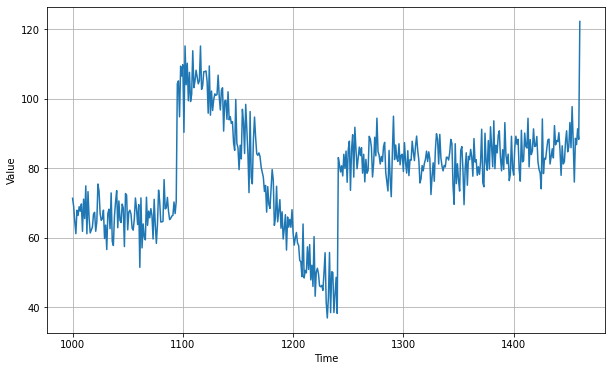

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [ ]:
# turn array of data to dataset for training

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)                    # expand dimensions
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# tf.keras.backend.clear_session()                    # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

In [ ]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [ ]:
model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 200)                              # scale outputs by 200
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=10)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [ ]:
epochs = 100
callbacks = [early_stopping, model_checkpoint, lr_schedule]

In [ ]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/100
8/8 [==============================] - 36s 41ms/step - loss: 100.1553 - mae: 100.6553
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 98.7825 - mae: 99.2825
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - loss: 96.5452 - mae: 97.0452
Epoch 4/100
8/8 [==============================] - 0s 32ms/step - loss: 93.7069 - mae: 94.2069
Epoch 5/100
8/8 [==============================] - 0s 32ms/step - loss: 90.3371 - mae: 90.8371
Epoch 6/100
8/8 [==============================] - 0s 32ms/step - loss: 86.4303 - mae: 86.9303
Epoch 7/100
8/8 [==============================] - 0s 32ms/step - loss: 81.8991 - mae: 82.3990
Epoch 8/100
8/8 [==============================] - 0s 32ms/step - loss: 76.6429 - mae: 77.1429
Epoch 9/100
8/8 [==============================] - 0s 32ms/step - loss: 70.2651 - mae: 70.7651
Epoch 10/100
8/8 [==============================] - 0s 31ms/step - loss: 61.6693 - mae: 62.1693
Epoch 11/100
8/8 [============================

(1e-08, 0.0001, 0.0, 30.0)

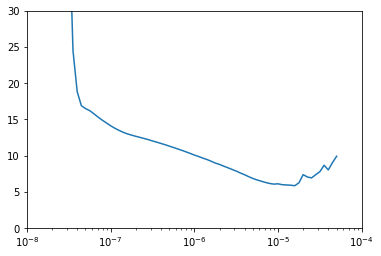

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
# making new model by fixing learning rate

model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 200)                              # scale outputs by 200
])

In [ ]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=70)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 500
callbacks = [early_stopping, model_checkpoint]

In [ ]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/500
8/8 [==============================] - 7s 32ms/step - loss: 26.7238 - mae: 27.2198
Epoch 2/500
8/8 [==============================] - 0s 32ms/step - loss: 13.0727 - mae: 13.5653
Epoch 3/500
8/8 [==============================] - 0s 30ms/step - loss: 10.4327 - mae: 10.9232
Epoch 4/500
8/8 [==============================] - 0s 31ms/step - loss: 8.5419 - mae: 9.0286
Epoch 5/500
8/8 [==============================] - 0s 32ms/step - loss: 6.9915 - mae: 7.4735
Epoch 6/500
8/8 [==============================] - 0s 33ms/step - loss: 6.5562 - mae: 7.0369
Epoch 7/500
8/8 [==============================] - 0s 31ms/step - loss: 6.3309 - mae: 6.8119
Epoch 8/500
8/8 [==============================] - 0s 32ms/step - loss: 6.2170 - mae: 6.6967
Epoch 9/500
8/8 [==============================] - 0s 32ms/step - loss: 6.1687 - mae: 6.6483
Epoch 10/500
8/8 [==============================] - 0s 33ms/step - loss: 6.0554 - mae: 6.5348
Epoch 11/500
8/8 [==============================] - 0s 32ms/ste

In [ ]:
# for forecasting after training

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

In [ ]:
rnn_forecast

array([[47.925434],
       [47.606834],
       [47.181774],
       ...,
       [86.02065 ],
       [85.83856 ],
       [86.881   ]], dtype=float32)

In [ ]:
split_time

1000

In [ ]:
window_size

30

In [ ]:
rnn_forecast[970:-1, -1]

array([63.20657 , 63.89599 , 64.010506, 64.541626, 64.21226 , 64.81488 ,
       64.69838 , 64.90224 , 65.47839 , 66.002174, 65.86321 , 65.953354,
       66.2049  , 66.655594, 66.107635, 66.31178 , 66.6631  , 67.14389 ,
       67.03868 , 67.59244 , 67.159485, 67.667404, 67.5795  , 67.25086 ,
       67.57816 , 68.21477 , 67.53312 , 67.066246, 67.34291 , 67.71596 ,
       67.227684, 67.14398 , 66.6669  , 66.85127 , 67.18613 , 67.264755,
       66.842476, 66.65239 , 65.84279 , 65.95935 , 66.0418  , 66.55967 ,
       65.478584, 65.70033 , 65.49976 , 65.87856 , 66.1761  , 66.7203  ,
       66.25859 , 66.18185 , 66.28455 , 66.194824, 65.8601  , 65.94683 ,
       66.09884 , 66.18583 , 66.25246 , 66.622665, 66.64963 , 67.17521 ,
       66.49341 , 66.48196 , 66.548584, 65.87796 , 66.284935, 65.3173  ,
       65.198845, 65.70935 , 65.647896, 65.75438 , 64.93245 , 65.17624 ,
       65.34143 , 65.586975, 65.45074 , 65.23503 , 64.98515 , 64.69196 ,
       64.90352 , 65.15525 , 65.834755, 65.34167 , 

In [ ]:
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

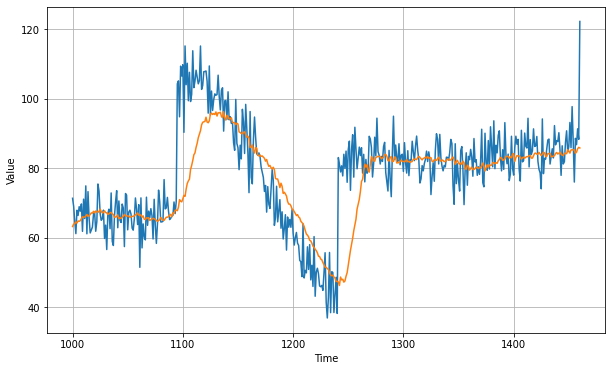

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

7.028775

<Figure size 432x288 with 0 Axes>

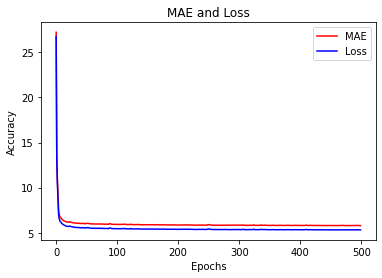

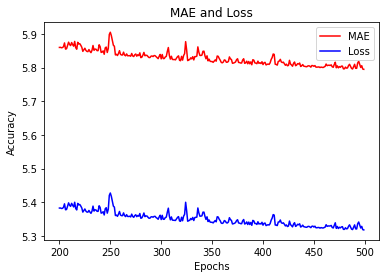

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## Sunspots Data - Dense

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /content/sunspots.csv

--2021-10-22 04:52:44--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.251.8.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/content/sunspots.csv’

/content/sunspots.c 100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-10-22 04:52:44 (66.2 MB/s) - ‘/content/sunspots.csv’ saved [70827/70827]



In [ ]:
import pandas as pd

df = pd.read_csv('/content/sunspots.csv', delimiter=',')
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [ ]:
df.tail()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
3230,3230,2018-03-31,2.5
3231,3231,2018-04-30,8.9
3232,3232,2018-05-31,13.2
3233,3233,2018-06-30,15.9
3234,3234,2018-07-31,1.6


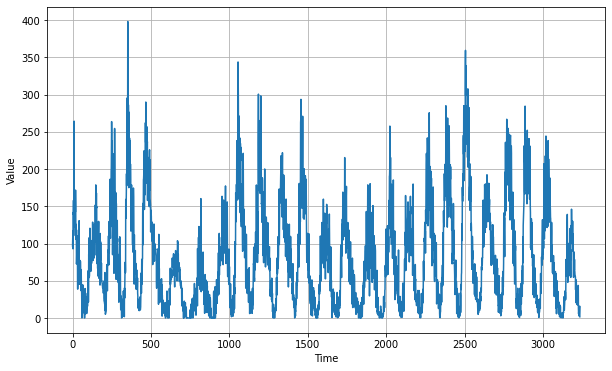

In [ ]:
import csv
time_step = []
sunspots = []

with open('/content/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)                                    # throwing away 1st line which has column headers
    for row in reader:
        sunspots.append(float(row[2]))                # taking sunspots data from col 2
        time_step.append(int(row[0]))                 # taking time steps data from col 1

# convert to arrays

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

# seasonality and noise present but no noticeable trend
# data is monthwise
# so seasonality is close around 11 yrs (or less than 125 months), see from the graph

In [ ]:
series[:10]

array([ 96.7, 104.3, 116.7,  92.8, 141.7, 139.2, 158. , 110.5, 126.5,
       125.8])

In [ ]:
time[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60                              # 60 months, each time slice is a month
batch_size = 32
shuffle_buffer_size = 1000

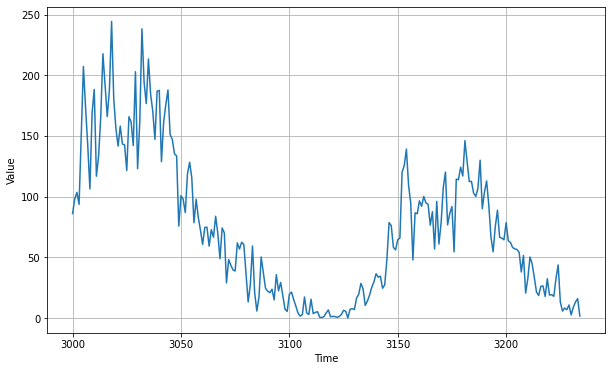

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
tf.random.set_seed(51)
np.random.seed(51)

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = Sequential([
    layers.InputLayer(input_shape=[window_size]),                
    layers.Dense(20, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=10)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [ ]:
epochs = 120
callbacks = [early_stopping, model_checkpoint, lr_schedule]

In [ ]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/120
92/92 [==============================] - 2s 7ms/step - loss: 57.2872 - mae: 57.7842
Epoch 2/120
92/92 [==============================] - 1s 7ms/step - loss: 56.8865 - mae: 57.3838
Epoch 3/120
92/92 [==============================] - 1s 8ms/step - loss: 56.4282 - mae: 56.9261
Epoch 4/120
92/92 [==============================] - 1s 8ms/step - loss: 55.9037 - mae: 56.4016
Epoch 5/120
92/92 [==============================] - 1s 7ms/step - loss: 55.3038 - mae: 55.8017
Epoch 6/120
92/92 [==============================] - 1s 7ms/step - loss: 54.6195 - mae: 55.1173
Epoch 7/120
92/92 [==============================] - 1s 7ms/step - loss: 53.8399 - mae: 54.3371
Epoch 8/120
92/92 [==============================] - 1s 7ms/step - loss: 52.9522 - mae: 53.4500
Epoch 9/120
92/92 [==============================] - 1s 7ms/step - loss: 51.9417 - mae: 52.4387
Epoch 10/120
92/92 [==============================] - 1s 7ms/step - loss: 50.8006 - mae: 51.2976
Epoch 11/120
92/92 [===================

(1e-08, 0.001, 10.0, 50.0)

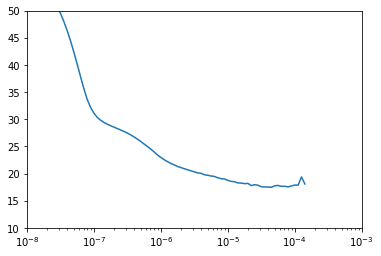

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-3, 10, 50])

In [ ]:
model = Sequential([
    layers.InputLayer(input_shape=[window_size]),                
    layers.Dense(20, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [ ]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=70)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 400
callbacks = [early_stopping, model_checkpoint]

In [ ]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/400
92/92 [==============================] - 1s 8ms/step - loss: 27.7373 - mae: 28.2315
Epoch 2/400
92/92 [==============================] - 1s 7ms/step - loss: 20.0178 - mae: 20.5108
Epoch 3/400
92/92 [==============================] - 1s 7ms/step - loss: 18.9031 - mae: 19.3964
Epoch 4/400
92/92 [==============================] - 1s 6ms/step - loss: 18.2329 - mae: 18.7245
Epoch 5/400
92/92 [==============================] - 1s 8ms/step - loss: 18.2480 - mae: 18.7416
Epoch 6/400
92/92 [==============================] - 1s 7ms/step - loss: 18.2176 - mae: 18.7096
Epoch 7/400
92/92 [==============================] - 1s 7ms/step - loss: 17.9885 - mae: 18.4811
Epoch 8/400
92/92 [==============================] - 1s 7ms/step - loss: 17.6364 - mae: 18.1291
Epoch 9/400
92/92 [==============================] - 1s 7ms/step - loss: 17.5024 - mae: 17.9952
Epoch 10/400
92/92 [==============================] - 1s 7ms/step - loss: 17.9474 - mae: 18.4391
Epoch 11/400
92/92 [===================

<function matplotlib.pyplot.show>

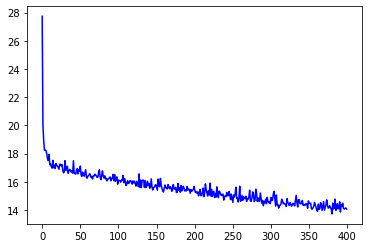

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show

<Figure size 432x288 with 0 Axes>

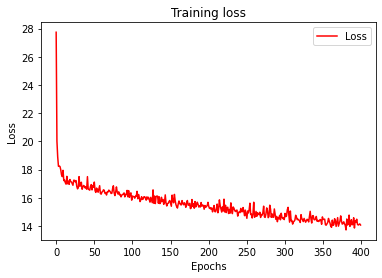

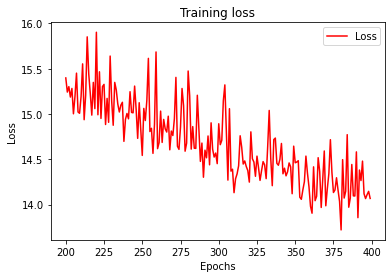

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,400)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

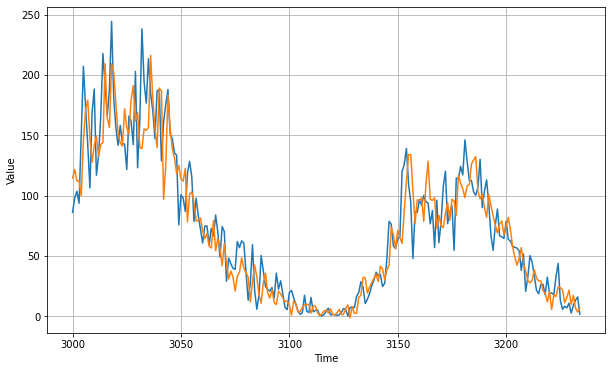

In [ ]:
forecast=[]

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

16.367146

## Sunspots Data - CNN + LSTM + Dense

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /content/sunspots.csv

--2021-10-22 08:32:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 64.233.184.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/content/sunspots.csv’

/content/sunspots.c 100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-10-22 08:32:36 (97.8 MB/s) - ‘/content/sunspots.csv’ saved [70827/70827]



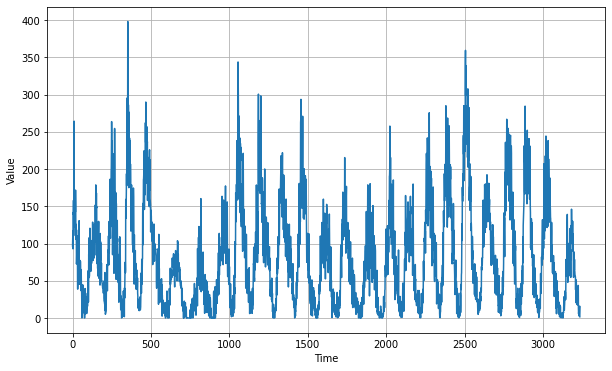

In [4]:
import csv
time_step = []
sunspots = []

with open('/content/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

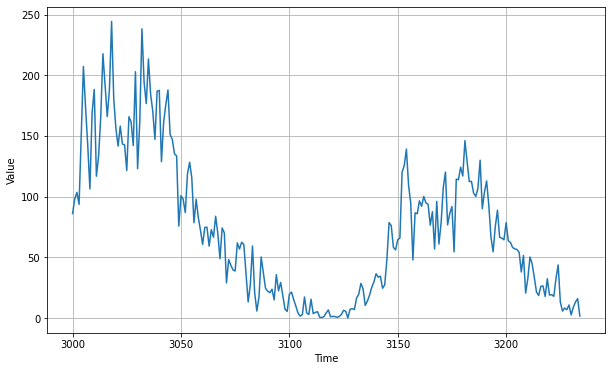

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
tf.random.set_seed(51)
np.random.seed(51)

In [9]:
window_size = 30
batch_size = 64

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [11]:
dataset

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [12]:
x_train.shape

(3000,)

In [13]:
model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400)                              # scale outputs by 400
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 30)                1950      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0

In [15]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [16]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [17]:
early_stopping    = EarlyStopping(monitor='loss', patience=20)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [18]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

In [19]:
epochs = 100
callbacks = [early_stopping, model_checkpoint, lr_schedule]

In [20]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/100
47/47 [==============================] - 6s 20ms/step - loss: 57.6283 - mae: 58.1252
Epoch 2/100
47/47 [==============================] - 1s 20ms/step - loss: 41.9827 - mae: 42.4799
Epoch 3/100
47/47 [==============================] - 1s 20ms/step - loss: 37.3267 - mae: 37.8235
Epoch 4/100
47/47 [==============================] - 1s 20ms/step - loss: 34.9898 - mae: 35.4862
Epoch 5/100
47/47 [==============================] - 1s 20ms/step - loss: 33.4818 - mae: 33.9776
Epoch 6/100
47/47 [==============================] - 1s 20ms/step - loss: 32.2921 - mae: 32.7877
Epoch 7/100
47/47 [==============================] - 1s 21ms/step - loss: 31.3348 - mae: 31.8305
Epoch 8/100
47/47 [==============================] - 1s 21ms/step - loss: 30.5445 - mae: 31.0403
Epoch 9/100
47/47 [==============================] - 1s 21ms/step - loss: 29.8994 - mae: 30.3949
Epoch 10/100
47/47 [==============================] - 1s 20ms/step - loss: 29.3125 - mae: 29.8081
Epoch 11/100
47/47 [=========

(1e-07, 0.001, 15.0, 50.0)

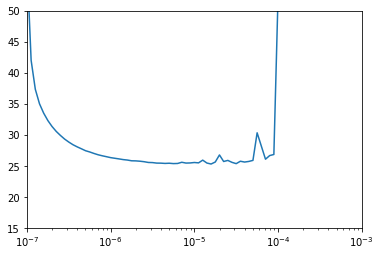

In [21]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-3, 15, 50])

In [22]:
history.history

{'loss': [57.628292083740234,
  41.98267364501953,
  37.326683044433594,
  34.989845275878906,
  33.481788635253906,
  32.292057037353516,
  31.33481216430664,
  30.544466018676758,
  29.89939308166504,
  29.31252670288086,
  28.831422805786133,
  28.403867721557617,
  28.060808181762695,
  27.75543785095215,
  27.4387149810791,
  27.23826789855957,
  27.001684188842773,
  26.78849983215332,
  26.623153686523438,
  26.477685928344727,
  26.326494216918945,
  26.223798751831055,
  26.120580673217773,
  26.01048469543457,
  25.938047409057617,
  25.819305419921875,
  25.80286979675293,
  25.750938415527344,
  25.6705265045166,
  25.55086898803711,
  25.52890396118164,
  25.446857452392578,
  25.437231063842773,
  25.39543342590332,
  25.425596237182617,
  25.36812973022461,
  25.387535095214844,
  25.5797119140625,
  25.45229148864746,
  25.470510482788086,
  25.5416316986084,
  25.484146118164062,
  25.922117233276367,
  25.456085205078125,
  25.299007415771484,
  25.6230525970459,
  26

In [23]:
model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400)                              # scale outputs by 400
])

In [24]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [25]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [26]:
early_stopping    = EarlyStopping(monitor='loss', patience=60)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [27]:
epochs = 400
callbacks = [early_stopping, model_checkpoint]

In [28]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/400
47/47 [==============================] - 5s 21ms/step - loss: 30.7991 - mae: 31.2948
Epoch 2/400
47/47 [==============================] - 1s 20ms/step - loss: 26.6779 - mae: 27.1731
Epoch 3/400
47/47 [==============================] - 1s 20ms/step - loss: 26.2542 - mae: 26.7489
Epoch 4/400
47/47 [==============================] - 1s 20ms/step - loss: 25.8661 - mae: 26.3607
Epoch 5/400
47/47 [==============================] - 1s 20ms/step - loss: 25.9080 - mae: 26.4027
Epoch 6/400
47/47 [==============================] - 1s 20ms/step - loss: 25.4549 - mae: 25.9492
Epoch 7/400
47/47 [==============================] - 1s 20ms/step - loss: 25.4405 - mae: 25.9345
Epoch 8/400
47/47 [==============================] - 1s 20ms/step - loss: 25.4525 - mae: 25.9469
Epoch 9/400
47/47 [==============================] - 1s 20ms/step - loss: 25.2660 - mae: 25.7604
Epoch 10/400
47/47 [==============================] - 1s 20ms/step - loss: 25.3500 - mae: 25.8440
Epoch 11/400
47/47 [=========

<Figure size 432x288 with 0 Axes>

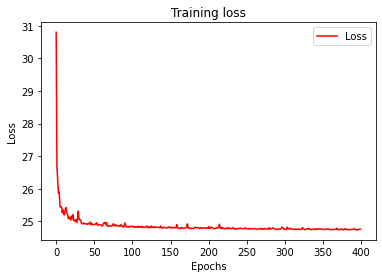

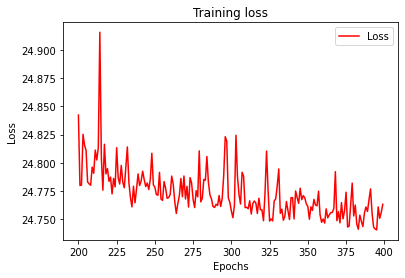

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,400)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [35]:
best_model = tf.keras.models.load_model('best_model.h5')

In [36]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = best_model.predict(ds)
    return forecast

In [37]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

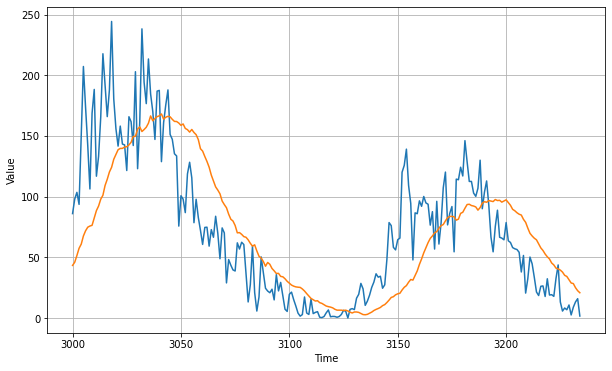

In [38]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [39]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

30.963919

In [40]:
model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400)                              # scale outputs by 400
])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 64)          16896     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1950      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
_________________________________________________________________
lambda_2 (Lambda)            (None, 1)                 0         
Total params: 52,191
Trainable params: 52,191
Non-trainable params: 0
__________________________________________________

In [42]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [43]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [44]:
early_stopping    = EarlyStopping(monitor='loss', patience=20)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [45]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

In [46]:
epochs = 100
callbacks = [early_stopping, model_checkpoint, lr_schedule]

In [47]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/100
47/47 [==============================] - 4s 19ms/step - loss: 178.9198 - mae: 179.4198
Epoch 2/100
47/47 [==============================] - 1s 19ms/step - loss: 122.1926 - mae: 122.6925
Epoch 3/100
47/47 [==============================] - 1s 19ms/step - loss: 74.9378 - mae: 75.4365
Epoch 4/100
47/47 [==============================] - 1s 18ms/step - loss: 57.2640 - mae: 57.7610
Epoch 5/100
47/47 [==============================] - 1s 19ms/step - loss: 51.9001 - mae: 52.3965
Epoch 6/100
47/47 [==============================] - 1s 19ms/step - loss: 48.6715 - mae: 49.1680
Epoch 7/100
47/47 [==============================] - 1s 20ms/step - loss: 45.9837 - mae: 46.4802
Epoch 8/100
47/47 [==============================] - 1s 19ms/step - loss: 43.5025 - mae: 43.9987
Epoch 9/100
47/47 [==============================] - 1s 20ms/step - loss: 41.2544 - mae: 41.7503
Epoch 10/100
47/47 [==============================] - 1s 19ms/step - loss: 39.3436 - mae: 39.8398
Epoch 11/100
47/47 [=====

(1e-07, 0.001, 15.0, 50.0)

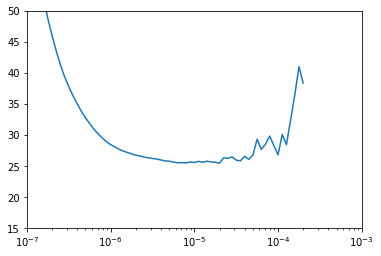

In [48]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-3, 15, 50])

## Exercise 16 - CNN + LSTM + Dense

For this week’s exercise, you’ll use a dataset from Jason Brownlee, author of the amazing MachineLearningMastery.com site and who has shared lots of datasets at https://github.com/jbrownlee/Datasets. It’s a dataset of daily minimum temperatures in the city of Melbourne, Australia measured from 1981 to 1990.  Your task is to download the dataset, parse the CSV, create a time series and build a prediction model from it. Your model should have an MAE of less than 2, and as you can see in the output, mine had 1.78. I’m sure you can beat that! :)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /content/daily-min-temperatures.csv

--2021-10-22 09:17:44--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/content/daily-min-temperatures.csv’

/content/daily-min- 100%[===================>]  66.33K  --.-KB/s    in 0.005s  

2021-10-22 09:17:44 (12.1 MB/s) - ‘/content/daily-min-temperatures.csv’ saved [67921/67921]



In [9]:
import pandas as pd

df = pd.read_csv('/content/daily-min-temperatures.csv', delimiter=',')
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [10]:
df.tail()

,Date,Temp
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


In [11]:
df.shape

(3650, 2)

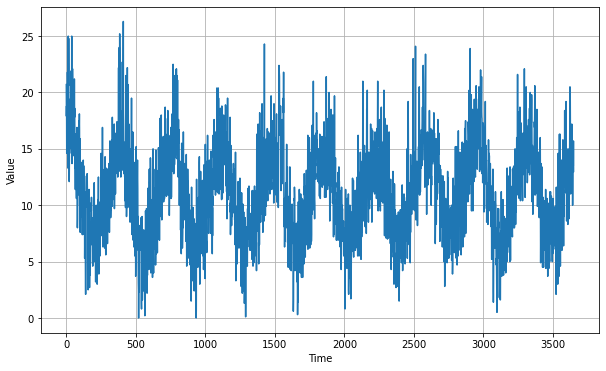

In [4]:
import csv
time_step = []
temps = []

with open('/content/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [54]:
time_step[:5]

[0, 1, 2, 3, 4]

In [53]:
temps[:5]

[20.7, 17.9, 18.8, 14.6, 15.8]

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

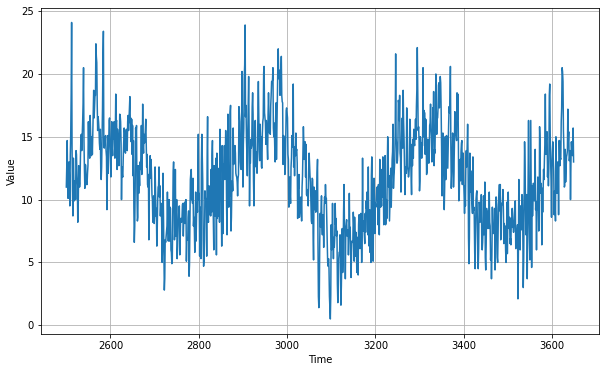

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
tf.random.set_seed(51)
np.random.seed(51)

In [12]:
window_size = 64
batch_size = 256

In [13]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [14]:
x_train.shape

(2500,)

In [19]:
model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400)                              # scale outputs by 400
])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1950      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                

In [21]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [22]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [23]:
early_stopping    = EarlyStopping(monitor='loss', patience=20)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [24]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [25]:
epochs = 100
callbacks = [early_stopping, model_checkpoint, lr_schedule]

In [26]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/100
10/10 [==============================] - 5s 47ms/step - loss: 96.7360 - mae: 97.2360
Epoch 2/100
10/10 [==============================] - 1s 50ms/step - loss: 92.9148 - mae: 93.4148
Epoch 3/100
10/10 [==============================] - 1s 46ms/step - loss: 87.0957 - mae: 87.5957
Epoch 4/100
10/10 [==============================] - 1s 48ms/step - loss: 80.3089 - mae: 80.8089
Epoch 5/100
10/10 [==============================] - 1s 44ms/step - loss: 73.0865 - mae: 73.5865
Epoch 6/100
10/10 [==============================] - 1s 50ms/step - loss: 65.5144 - mae: 66.0144
Epoch 7/100
10/10 [==============================] - 1s 51ms/step - loss: 57.4051 - mae: 57.9051
Epoch 8/100
10/10 [==============================] - 1s 51ms/step - loss: 48.7406 - mae: 49.2406
Epoch 9/100
10/10 [==============================] - 1s 51ms/step - loss: 39.8877 - mae: 40.3877
Epoch 10/100
10/10 [==============================] - 1s 48ms/step - loss: 31.8233 - mae: 32.3233
Epoch 11/100
10/10 [=========

(1e-08, 0.001, 0.0, 60.0)

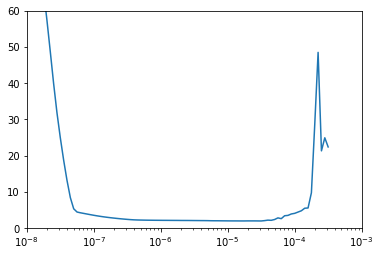

In [28]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 60])

In [30]:
model = Sequential([
    layers.InputLayer(input_shape=[None, 1]),                     # [None,1] means model can take sequences of any length with 1 feature
    layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400)                              # scale outputs by 400
])

In [31]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [32]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [33]:
early_stopping    = EarlyStopping(monitor='loss', patience=60)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [34]:
epochs = 200
callbacks = [early_stopping, model_checkpoint]

In [35]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/200
10/10 [==============================] - 4s 38ms/step - loss: 18.1552 - mae: 18.6496
Epoch 2/200
10/10 [==============================] - 1s 48ms/step - loss: 4.4213 - mae: 4.9006
Epoch 3/200
10/10 [==============================] - 1s 51ms/step - loss: 2.7164 - mae: 3.1828
Epoch 4/200
10/10 [==============================] - 1s 51ms/step - loss: 2.2610 - mae: 2.7202
Epoch 5/200
10/10 [==============================] - 1s 53ms/step - loss: 2.1658 - mae: 2.6237
Epoch 6/200
10/10 [==============================] - 1s 50ms/step - loss: 2.1031 - mae: 2.5596
Epoch 7/200
10/10 [==============================] - 1s 50ms/step - loss: 2.1228 - mae: 2.5798
Epoch 8/200
10/10 [==============================] - 1s 51ms/step - loss: 2.0837 - mae: 2.5402
Epoch 9/200
10/10 [==============================] - 1s 51ms/step - loss: 2.0706 - mae: 2.5272
Epoch 10/200
10/10 [==============================] - 1s 49ms/step - loss: 2.0916 - mae: 2.5478
Epoch 11/200
10/10 [===========================

In [37]:
best_model = tf.keras.models.load_model('best_model.h5')

In [38]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = best_model.predict(ds)
    return forecast

In [39]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

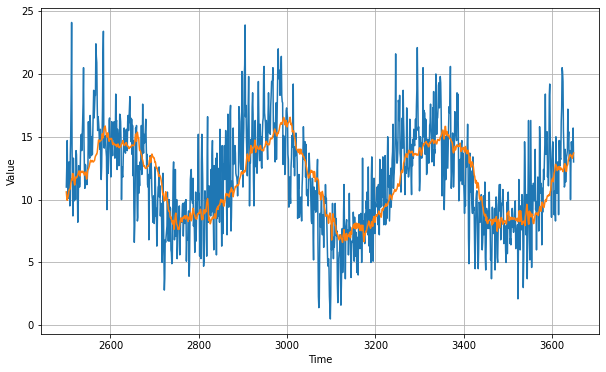

In [40]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [41]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.2801964

## Exercise 16 - Dense

In [62]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [63]:
tf.random.set_seed(51)
np.random.seed(51)

In [67]:
window_size = 64
batch_size = 256

In [68]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [78]:
model = Sequential([
    layers.InputLayer(input_shape=[window_size]),                
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [70]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                1300      
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________


In [81]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [82]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [83]:
early_stopping    = EarlyStopping(monitor='loss', patience=25)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [84]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [85]:
epochs = 200
callbacks = [early_stopping, model_checkpoint, lr_schedule]

In [86]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/200
10/10 [==============================] - 1s 32ms/step - loss: 38.7526 - mae: 39.2526
Epoch 2/200
10/10 [==============================] - 1s 33ms/step - loss: 38.7449 - mae: 39.2449
Epoch 3/200
10/10 [==============================] - 1s 30ms/step - loss: 38.7332 - mae: 39.2332
Epoch 4/200
10/10 [==============================] - 1s 31ms/step - loss: 38.7190 - mae: 39.2190
Epoch 5/200
10/10 [==============================] - 1s 32ms/step - loss: 38.7027 - mae: 39.2027
Epoch 6/200
10/10 [==============================] - 1s 31ms/step - loss: 38.6842 - mae: 39.1842
Epoch 7/200
10/10 [==============================] - 1s 30ms/step - loss: 38.6635 - mae: 39.1635
Epoch 8/200
10/10 [==============================] - 1s 33ms/step - loss: 38.6403 - mae: 39.1403
Epoch 9/200
10/10 [==============================] - 1s 33ms/step - loss: 38.6141 - mae: 39.1141
Epoch 10/200
10/10 [==============================] - 1s 30ms/step - loss: 38.5849 - mae: 39.0849
Epoch 11/200
10/10 [=========

(1e-08, 0.01, 0.0, 40.0)

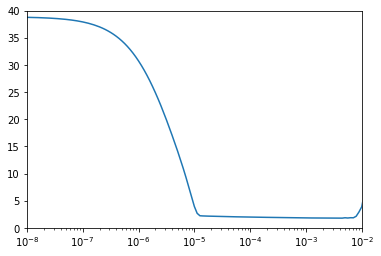

In [88]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-2, 0, 40])

In [89]:
history.history

{'loss': [38.75257873535156,
  38.74491882324219,
  38.733177185058594,
  38.71897506713867,
  38.70265197753906,
  38.68422317504883,
  38.66351318359375,
  38.6402587890625,
  38.6141471862793,
  38.584861755371094,
  38.552162170410156,
  38.515384674072266,
  38.47419738769531,
  38.42813491821289,
  38.376461029052734,
  38.318668365478516,
  38.25391387939453,
  38.18158721923828,
  38.1005973815918,
  38.0101318359375,
  37.90814208984375,
  37.7951545715332,
  37.668209075927734,
  37.526851654052734,
  37.36886978149414,
  37.1933479309082,
  36.99766159057617,
  36.7795295715332,
  36.53744125366211,
  36.26811981201172,
  35.96986770629883,
  35.6396484375,
  35.2751350402832,
  34.87151336669922,
  34.4271125793457,
  33.93974685668945,
  33.40248489379883,
  32.8166389465332,
  32.1759033203125,
  31.481042861938477,
  30.72798728942871,
  29.916221618652344,
  29.04261589050293,
  28.106033325195312,
  27.108518600463867,
  26.046812057495117,
  24.92559814453125,
  23.74

In [90]:
model = Sequential([
    layers.InputLayer(input_shape=[window_size]),                
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

In [91]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [92]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [93]:
early_stopping    = EarlyStopping(monitor='loss', patience=60)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [94]:
epochs = 100
callbacks = [early_stopping, model_checkpoint]

In [95]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/100
10/10 [==============================] - 1s 32ms/step - loss: 9.8862 - mae: 10.3784
Epoch 2/100
10/10 [==============================] - 1s 31ms/step - loss: 3.7085 - mae: 4.1857
Epoch 3/100
10/10 [==============================] - 1s 33ms/step - loss: 2.4973 - mae: 2.9621
Epoch 4/100
10/10 [==============================] - 1s 29ms/step - loss: 2.1225 - mae: 2.5816
Epoch 5/100
10/10 [==============================] - 1s 33ms/step - loss: 1.9511 - mae: 2.4067
Epoch 6/100
10/10 [==============================] - 1s 32ms/step - loss: 1.8866 - mae: 2.3409
Epoch 7/100
10/10 [==============================] - 1s 31ms/step - loss: 1.8430 - mae: 2.2964
Epoch 8/100
10/10 [==============================] - 1s 32ms/step - loss: 1.8342 - mae: 2.2869
Epoch 9/100
10/10 [==============================] - 1s 31ms/step - loss: 1.8273 - mae: 2.2801
Epoch 10/100
10/10 [==============================] - 1s 33ms/step - loss: 1.8248 - mae: 2.2776
Epoch 11/100
10/10 [============================

In [96]:
best_model = tf.keras.models.load_model('best_model.h5')

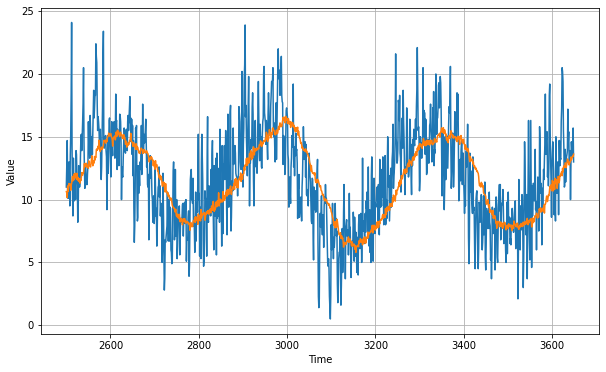

In [101]:
forecast=[]

for time in range(len(series) - window_size):
    forecast.append(best_model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [102]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.3595462